In [6]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [7]:
# Dimensionality of the latent space: a 2D plane
latent_dim = 2

# Define input layer for the encoder, representing the input image
encoder_inputs = keras.Input(shape=(28, 28, 1))

# Convolutional layer with 32 filters, 3x3 kernel size, ReLU activation, and stride of 2 to downsample the input image
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)

# Convolutional layer with 64 filters, 3x3 kernel size, ReLU activation, and stride of 2 to further downsample the image
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)

# Flatten the output tensor to prepare for feeding into fully connected layers
x = layers.Flatten()(x)

# Fully connected layer with 16 units and ReLU activation
x = layers.Dense(16, activation="relu")(x)

# Dense layer producing the mean of the latent space representation
z_mean = layers.Dense(latent_dim, name="z_mean")(x)

# Dense layer producing the log variance of the latent space representation
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Define the encoder model, mapping from the input image to the mean and log variance of the latent space
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")


In [8]:
# keras.utils.plot_model(encoder)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_2[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 3136)         0           ['conv2d_3[0][0]']               
                                                                                            

In [15]:
# Define a custom layer to perform sampling in the latent space of the VAE
class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        # Determine the batch size and size of the latent space
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        
        # Generate random samples from a standard normal distribution
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        
        # Apply the reparameterization trick to sample from the specified Gaussian distribution
        # by multiplying the standard deviation (exp(0.5 * z_log_var)) with the random noise (epsilon)
        # and adding the mean (z_mean)
        # This ensures that gradients can flow through the sampling operation
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [16]:
# Input where we’ll feed z
latent_inputs = keras.Input(shape=(latent_dim,))

# Produce the same number of coefficients that we had at the level of the Flatten layer in the encoder
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)

# Revert the Flatten layer of the encoder.
x = layers.Reshape((7, 7, 64))(x)

# Revert the Conv2D layers of the encoder.
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)

# Revert the Conv2D layers of the encoder.
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)

# The output ends up with shape (28, 28, 1).
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)

# Define the decoder model, mapping from the latent space to the reconstructed image
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")


In [17]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_4 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 1)         289 

In [18]:
# Define a Variational Autoencoder (VAE) model. Subclass the keras.Model class
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        # Initialize the VAE model with encoder and decoder components
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
        # Instantiate a Sampler object to perform sampling in the latent space
        self.sampler = Sampler()
        
        # Define metrics to track during training
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    # Define custom metrics to be tracked during training
    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    # Define the training step for the VAE
    def train_step(self, data):
        # Open a GradientTape to record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # Encode the input data to obtain the mean and log variance of the latent space
            z_mean, z_log_var = self.encoder(data)
            
            # Sample from the latent space using the mean and log variance
            z = self.sampler(z_mean, z_log_var)
            
            # Decode the sampled latent vectors to reconstruct the input data
            reconstruction = self.decoder(z)
            
            # Calculate the reconstruction loss using binary crossentropy
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            
            # Calculate the KL divergence loss
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            
            # Calculate the total loss as the sum of reconstruction and KL divergence losses
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        
        # Compute the gradients of the total loss with respect to the trainable weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        
        # Update the model's weights using the optimizer
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # Update the metrics trackers with the computed losses
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        # Return a dictionary containing the tracked metrics for logging purposes
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [21]:
import numpy as np
from tensorflow import keras

# Load and preprocess the MNIST dataset
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

# Create an instance of the VAE model with the encoder and decoder
vae = VAE(encoder, decoder)

# Compile the VAE model with an Adam optimizer:
# NOTE that we don’t pass a loss argument in compile(), since the loss
# is already part of the train_step().
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)

# Train the VAE model on the MNIST dataset
# NOTE that we don’t pass targets in fit(), since train_step()
# doesn’t expect any.
vae.fit(mnist_digits, epochs=30, batch_size=128)


Epoch 1/30
547/547 [==============================] - 82s 150ms/step - total_loss: 177.2058 - reconstruction_loss: 174.0398 - kl_loss: 3.1659
Epoch 2/30
547/547 [==============================] - 78s 142ms/step - total_loss: 163.8026 - reconstruction_loss: 160.0887 - kl_loss: 3.7139
Epoch 3/30
547/547 [==============================] - 77s 141ms/step - total_loss: 159.5278 - reconstruction_loss: 155.7974 - kl_loss: 3.7303
Epoch 4/30
547/547 [==============================] - 78s 143ms/step - total_loss: 157.1885 - reconstruction_loss: 153.4249 - kl_loss: 3.7634
Epoch 5/30
547/547 [==============================] - 80s 146ms/step - total_loss: 155.5792 - reconstruction_loss: 151.8184 - kl_loss: 3.7607
Epoch 6/30
547/547 [==============================] - 77s 140ms/step - total_loss: 154.3425 - reconstruction_loss: 150.5854 - kl_loss: 3.7571
Epoch 7/30
547/547 [==============================] - 76s 139ms/step - total_loss: 153.4465 - reconstruction_loss: 149.6949 - kl_loss: 3.7516
Epoch 

1/1 [==============================] - 0s 39ms/step


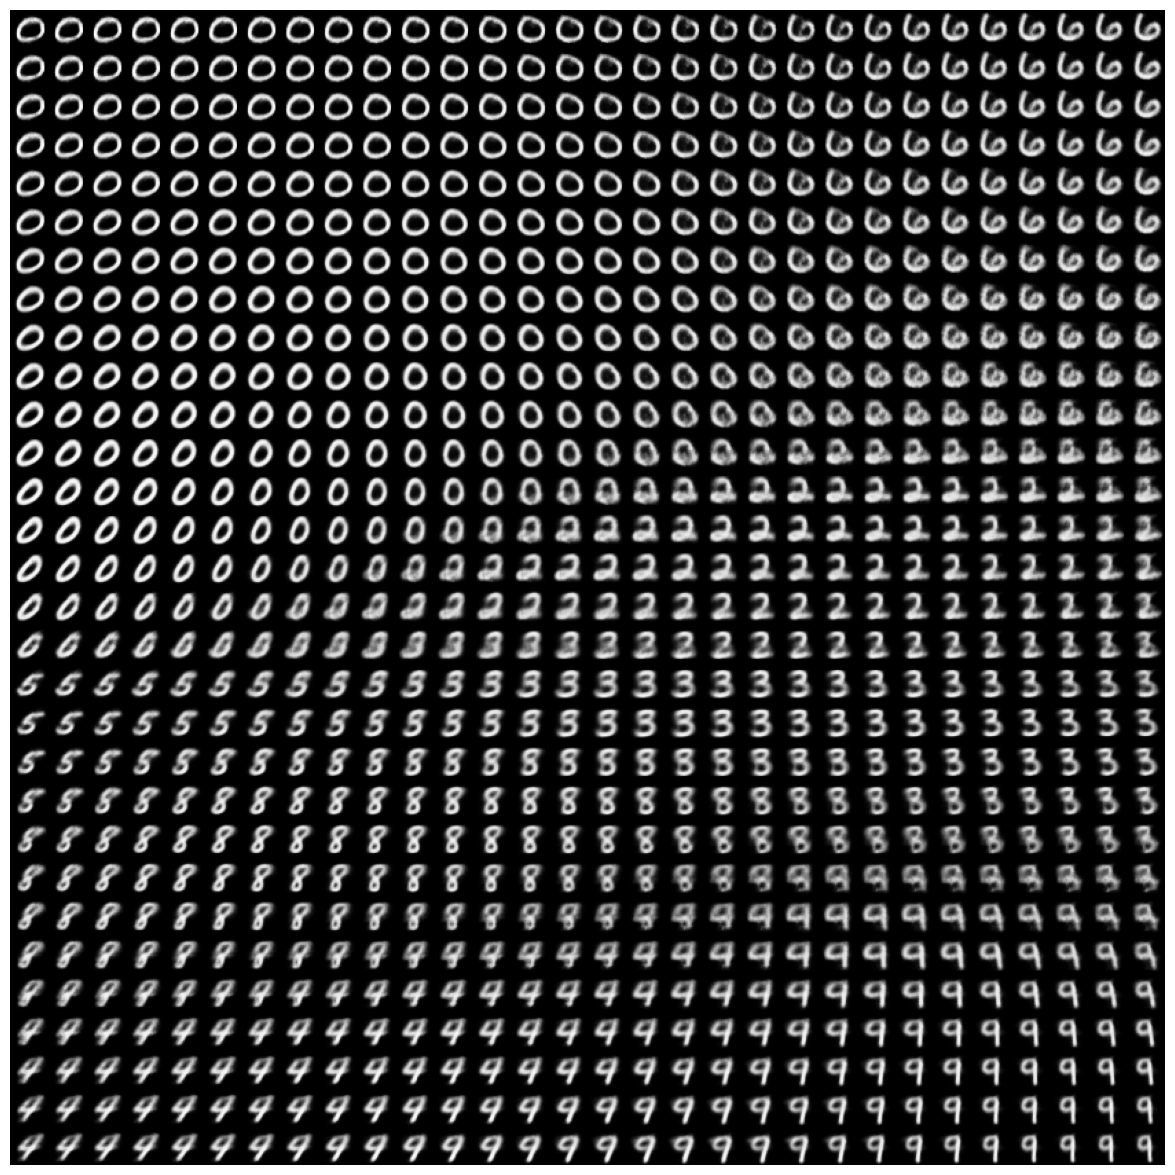

In [22]:
import matplotlib.pyplot as plt

# Number of points along each axis of the grid
n = 30

# Size of each digit in the grid
digit_size = 28

# Initialize an array to store the generated images
figure = np.zeros((digit_size * n, digit_size * n))

# Generate a grid of points in the latent space
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

# Loop over each point in the grid
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        # Sample a point from the latent space
        z_sample = np.array([[xi, yi]])
        
        # Decode the sampled point to generate an image
        x_decoded = vae.decoder.predict(z_sample)
        
        # Reshape the decoded image to the size of a digit
        digit = x_decoded[0].reshape(digit_size, digit_size)
        
        # Place the decoded digit into the figure array
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

# Plot the generated grid of images
plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")
plt.show()


1/1 [==============================] - 0s 23ms/step


In [66]:
import pandas as pd

result = vae.decoder.predict(np.array([[1, -1]]))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
df = pd.DataFrame(result.reshape((28,28))).round().replace(0, "")
df

1/1 [==============================] - 0s 37ms/step


0  1  2  3  4  5  6  7  8    9    10   11   12   13   14   15   16   17 18  \
0                                                                               
1                                                                               
2                                                                               
3                                                                               
4                                                                               
5                                                                               
6                                                                               
7                                        1.0  1.0  1.0  1.0  1.0  1.0           
8                                   1.0  1.0  1.0  1.0  1.0  1.0  1.0           
9                              1.0  1.0  1.0                 1.0  1.0           
10                             1.0  1.0                      1.0  1.0  1.0      
11                             1.0  1.0                      1.0  1.0  1.0      
12                             1.0                           1.0  1.0  1.0      
13                             1.0  1.0                      1.0  1.0  1.0      
14                             1.0  1.0  1.0       1.0  1.0  1.0  1.0  1.0      
15                             1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0      
16                                       1.0  1.0            1.0  1.0  1.0      
17                                                                1.0  1.0      
18                                                                1.0  1.0      
19                                                                1.0  1.0      
20                                                                1.0  1.0      
21                                                                1.0  1.0      
22                                                                1.0  1.0      
23                                                                1.0  1.0      
24                                                                1.0  1.0      
25                                                                     1.0      
26                                                                              
27                                                                              

   19 20 21 22 23 24 25 26 27  
0                              
1                              
2                              
3                              
4                              
5                              
6                              
7                              
8                              
9                              
10                             
11                             
12                             
13                             
14                             
15                             
16                             
17                             
18                             
19                             
20                             
21                             
22                             
23                             
24                             
25                             
26                             
27